# Übung 2 Detektion von Verkehrsschildern

**German Traffic Sign Detection Benchmark**

Detallierte Beschreibung des Datensatzes siehe unter folgendem [Link](http://benchmark.ini.rub.de/?section=gtsdb&subsection=news)

## Imports

In [1]:
import os

import csv
import wget
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [2]:
# Testfunktion für ipywidgets: 
# Es soll ein Slider angezeigt werden. Der Wertebereich des Sliders
# soll zwischen -10(min) und 30(max) liegen. 
# Entsprechend der Sliderposition soll ein Ergebniswert angezeigt werden.
def f(x):
    return 3 * x
interact(f, x= 10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

## Globale Variablen

Um hartcodierte Bezeichner/Namen in den Funktionen zu vermeiden, definiere an dieser Stelle alle Variablen, die global verwendet werden.

In [3]:
# Definiere den Pfad zum heruntergeladenen Datenordner
DATA_PATH = 'FullIJCNN2013'

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(DATA_PATH), "Der angegebene Pfad existriert nicht."

In [4]:
# Definiere den Pfad zur Datei gt.txt
GT_TXT_PATH = os.path.join(DATA_PATH, 'gt.txt')
assert os.path.exists(GT_TXT_PATH), "Der angegebene Pfad existriert nicht."

In [5]:
# Prohibitory Class IDs 
PROHIBITORY_CLASS_IDs = [ 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]

# Mandatory Class IDs
MANDATORY_CLASS_IDs = [ 33, 34, 35, 36, 37, 38, 39, 40 ]

# Danger Class IDs
DANGER_CLASS_IDs = [ 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

In [6]:
# Prohibitory-Dictionary 
PROHIBITORY_DICT = {}

In [7]:
# Prohibitory images (filenames) list
PROHIBITORY_IMG_LIST = []

In [8]:
# Prohibitory filepaths
PROHIBITORY_FILEPATHS = []

## Aufgabe 1 - Aussortieren bestimmter Verkehrsschilder

In [9]:
def calculate_prohibitory(): 
    """
    Sortiert Verkehrszeichen nach der Kategorie „prohibitory“ und speichert 
    die Ergebnisse in ein Dictionary.
    Das Dictionary beinhaltet Dateinamen als Schlüssel und Listen von 
    Ground Thruth ROIs-Listen als Values.
    """
    
    # Setze prohibitory dictionary zurück
    PROHIBITORY_DICT.clear()
    
    # Öffne die gt.txt-Datei
    with open(GT_TXT_PATH, newline='') as csvfile:
        gt_reader = csv.reader(csvfile, delimiter=';')
        pic_name=''
        values=list()
        # Bau eine Schleife, um die Daten Zeile für Zeile auszulesen 
        # und die entsprechende Liste der ROIs für die Datei zu füllen
        for row in gt_reader:
            ### TO DO ###
            if int(row[-1]) in PROHIBITORY_CLASS_IDs:
                values=[[int(a) for a in row[1:]]] if pic_name !=row[0] else values+[[int(a) for a in row[1:]]]
                pic_name=row[0]
                PROHIBITORY_DICT[pic_name]=values

                

In [10]:
# Funktionsaufruf
"""
Erwartete Ausgabe:
    {'00003.ppm': [[742, 443, 765, 466, 4], [742, 466, 764, 489, 9]],
     '00004.ppm': [[906, 407, 955, 459, 2]],
     '00005.ppm': [[1172, 164, 1284, 278, 9]],
     '00006.ppm': [[926, 350, 989, 414, 2]],
     ...}
"""
calculate_prohibitory()
print(PROHIBITORY_DICT)

{'00003.ppm': [[742, 443, 765, 466, 4], [742, 466, 764, 489, 9]], '00004.ppm': [[906, 407, 955, 459, 2]], '00005.ppm': [[1172, 164, 1284, 278, 9]], '00006.ppm': [[926, 350, 989, 414, 2]], '00007.ppm': [[825, 406, 864, 445, 9]], '00008.ppm': [[785, 460, 811, 486, 2]], '00009.ppm': [[925, 466, 949, 490, 4]], '00011.ppm': [[720, 338, 770, 398, 1]], '00012.ppm': [[979, 364, 1034, 418, 1]], '00013.ppm': [[1043, 281, 1120, 356, 2]], '00018.ppm': [[950, 455, 981, 486, 4]], '00019.ppm': [[845, 423, 888, 465, 2]], '00023.ppm': [[998, 292, 1074, 371, 1]], '00026.ppm': [[453, 411, 492, 451, 1]], '00027.ppm': [[969, 386, 1024, 441, 2], [102, 375, 157, 430, 2]], '00029.ppm': [[1091, 393, 1133, 436, 15]], '00053.ppm': [[1156, 333, 1196, 372, 15]], '00054.ppm': [[1117, 473, 1146, 502, 0]], '00056.ppm': [[729, 436, 760, 467, 1]], '00057.ppm': [[990, 418, 1036, 467, 1]], '00060.ppm': [[819, 441, 842, 464, 2]], '00061.ppm': [[1224, 333, 1285, 394, 2]], '00063.ppm': [[815, 499, 837, 521, 9]], '00064.ppm'

In [11]:
# Ermittele die Dateienamen (ausgehend von DATA_PATH) alle Treffer in PROHIBITORY_DICT
PROHIBITORY_FILEPATHS = [os.path.join(DATA_PATH, key) for  key,value in PROHIBITORY_DICT.items() ]
print(len(PROHIBITORY_FILEPATHS))

382


In [12]:
def render_prohibitory_rois():
    """
    Malt die ROIs (Rechtecke) auf die entsprechenden Bilder und speichert 
    die in PROHIBITORY_IMG_LIST. 
    Hinweis:
    Die ROIs und Bildernamen können aus PROHIBITORY_DICT ermittelt werden
    """
    # Setze die globale variable zurück
    PROHIBITORY_IMG_LIST.clear()
    
    for key in PROHIBITORY_DICT.keys():
        file_path = os.path.join(DATA_PATH, key)
        img = plt.imread(file_path)
        ### TO DO ###
        for idx in range(len(PROHIBITORY_DICT[key])):
            # Berechne Koordinaten des Rechtecks
            point1 = tuple(PROHIBITORY_DICT[key][idx][0:2])
            point2 = tuple(PROHIBITORY_DICT[key][idx][2:4])
            
            # Zeichne das Rechteck
            img =  cv2.rectangle(img=img,pt1=point1,pt2=point2,color=(255,0,0) ,thickness=4)
            org = (point1[0]-10,point1[1]-10)            
            # Speichere Verkehrszeichennamen als text
            text = str(PROHIBITORY_DICT[key][idx][-1])
            img = cv2.putText(img,text,org,cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,0),thickness=2)
            
        PROHIBITORY_IMG_LIST.append(img)

In [13]:
# Prohibitory Image list abrufen
render_prohibitory_rois()
print(len(PROHIBITORY_IMG_LIST))

382


In [14]:
def show_img(idx):
    plt.figure(figsize=(16,8))
    plt.imshow(PROHIBITORY_IMG_LIST[idx])
    plt.show()

In [16]:
interact(show_img, idx=widgets.IntSlider(min=0,max=len(PROHIBITORY_IMG_LIST)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='idx', max=381), Output()), _dom_classes=('widget-interac…

## Aufgabe 2 – Formbasierter Ansatz

In [17]:
def calculate_hough_cirles(filepaths, d_p, min_dist, param1, param2, min_radius, max_radius):
    """
     Berechnet Hough Circles unter Berücksichtigung der Form der Verkehrszeichen
    """
    
    # Liste fuer die Speicherung des Ergebnis
    result = []
    predicted_dict = {}
    
    for filepath_ in filepaths:
        # Lade das Bild in color_img
        color_img = cv2.imread(filepath_, cv2.IMREAD_COLOR)
        ### TO DO ###
        
        # Konvertiere das BGR-Bild in Gray.
        # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html?highlight=cvtcolor
        img_gray = cv2.cvtColor(color_img,cv2.COLOR_BGR2GRAY)

        # Reduziere das Rauschen 
        # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html?highlight=medianblur
        img_blurred =  cv2.medianBlur(img_gray,3)
        
        # Ermittele die Kreisen auf dem Bild 
        # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html#hough-circles
        circles = cv2.HoughCircles(img_blurred,cv2.HOUGH_GRADIENT,d_p,min_dist,
                            param1=param1,param2=param2,minRadius=min_radius,maxRadius=max_radius)

        # Kreise auf das Bild malen
        if circles is not None: 
            # Kreise-Paramater in interger umwandeln
            circles = np.uint16(np.around(circles)) 
            
            # Kreise auf das Bild malen
            for point in circles[0, :]: 
                a, b, r = point
                cv2.circle(color_img,(a,b),r,(0,255,0),2)
                # Ermittle Koordinaten der Rechtecke, die für die Evaluation benutzt werden
                point1 = (a-r,b-r)
                point2 = (a+r,b+r)
                # OPTIONAL: Rechtecke auf das Bild malen
                cv2.rectangle(color_img,point1,point2,(255,255,0),2)
                if os.path.split(filepath_)[-1] in predicted_dict:
                    if a==0 and b==0 and r==0:
                        continue
                    predicted_dict[os.path.split(filepath_)[-1]].append([point1[0], point1[1], point2[0], point2[1]])
                else: 
                    predicted_dict[os.path.split(filepath_)[-1]] = []
                    if a==0 and b==0 and r==0:
                        continue
                    predicted_dict[os.path.split(filepath_)[-1]].append([point1[0], point1[1], point2[0], point2[1]])
        else:
            predicted_dict[os.path.split(filepath_)[-1]] = []                
        result.append(color_img)
        
    return result, predicted_dict

In [18]:
pred_imgs_form, predicted_rect_rois = calculate_hough_cirles(PROHIBITORY_FILEPATHS, 
                                                  d_p=1,
                                                  min_dist=20, 
                                                  param1= 100, 
                                                  param2= 70, 
                                                  min_radius=10, 
                                                  max_radius=70) 

In [19]:
def show_img_form(idx):
    plt.figure(figsize=(16,8))
    plt.imshow(cv2.cvtColor(pred_imgs_form[idx], cv2.COLOR_BGR2RGB))
    plt.show()

In [20]:
interact(show_img_form, idx=widgets.IntSlider(min=0, max=len(pred_imgs_form)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='idx', max=381), Output()), _dom_classes=('widget-interac…

## Aufgabe 3 – Optimierung und Evaluation des formbasierten Ansatzes

In [21]:
def jaccard_similarity(pred, gr_truth):
    '''
    Berechnet den Jaccard-Koeffizienten für zwei Rechtecke: den vorhergesagen (pred) und den ground_truth (gr_truth)
    
    '''
    # Ermittle die (x, y)-Koordinaten der Schnittmenge beider Rechtecke
    x_i1 = max(pred[0], gr_truth[0])
    y_i1 = max(pred[1], gr_truth[1])
    x_i2 = min(pred[2], gr_truth[2])
    y_i2 = min(pred[3], gr_truth[3])

    inter_area = max(0, x_i2 - x_i1 + 1) * max(0, y_i2 - y_i1 + 1)

    pred_area = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    gr_truth_area = (gr_truth[2] - gr_truth[0] + 1) * (gr_truth[3] - gr_truth[1] + 1)
    
    iou = inter_area / float(pred_area + gr_truth_area - inter_area)
    
    # Gebe die "Intersection Over Union"-Wert zurück
    return iou

In [22]:
def evaluate_detection(ground_truth_dict, predicted_dict, similarity_threshold=0.6):    
    '''
    Evaluiert implementierte Ansätze anhand des Jaccard-Ähnlichkeitsmaßes
    Referenz für die Berechnung: Houben et. al. Kapitel IV Evaluation Procedure
    tp: true positive - Das tatsächlich vorhandene Schild wurde vom Detektionsverfahren korrekt erkannt
    fp: false positive- Ein Schild wird detektiert, obwohl keins vorhanden ist
    fn: false negative- Ein Schild ist vorhanden, wird aber nicht detektiert
    tn: true negative - Es ist kein Schild vorhanden und es wird keins detektiert.
    '''
    # True Positives
    tp = 0
    # False Positives
    fp = 0
    # False Negatives
    fn = 0
    
    for key in ground_truth_dict.keys():
        # Liste mit allen ROIs eines Dateinamens 
        rois_gt_lists = ground_truth_dict[key]
        
        # Berechne Jaccard-Ähnlichkeitsmaß von detektierten Rechtecken, die aus den Kreiskoordinaten ermittelt wurden
        rois_pred_lists = predicted_dict[key]
        
        if len(rois_pred_lists) > 0:
            for rois_gt_list in rois_gt_lists:
                iou = [jaccard_similarity(rois_pred, rois_gt_list) for rois_pred in rois_pred_lists]
                
                # Liste mit den Werten, die kleiner als similarity_threshold sind
                iou_lt_threshold = [value for value in iou if value < similarity_threshold]
                fp = fp + len(iou_lt_threshold)
                
                # Liste mit den Werten, die größer / gleich similarity_threshold sind
                iou_gt_threshold = [value for value in iou if value >= similarity_threshold]
                
                if len(iou_gt_threshold) > 0 : 
                    tp = tp + 1
                else:
                    fn = fn + 1
        else:
            fn = fn + len(rois_gt_lists)

    return tp, fp, fn            

In [23]:
def calculate_precision_recall(tp, fp, fn):
    '''
    Berechnet Precision- und Recall-Werte
    '''
    
    precision = np.NaN
    if tp + fp != 0:
        precision = tp / (tp + fp)   
    
    recall = np.NaN
    if tp + fn != 0:
        recall = tp / (tp + fn)
        
    return precision, recall

In [24]:
# similarity_threshold entspricht dem Schwellenwert im Paper von Houben et. al.
tp_form, fp_form, fn_form = evaluate_detection(PROHIBITORY_DICT, predicted_rect_rois, similarity_threshold=0.6)

D:\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in ushort_scalars
D:\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ushort_scalars
  if sys.path[0] == '':
D:\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ushort_scalars
  


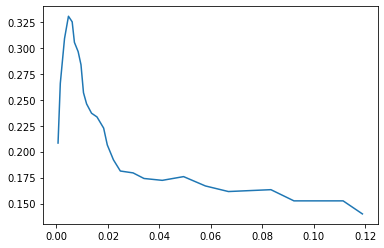

In [46]:
# Precision-Recall-Plot
### TO DO ###

###testing parameter 1-> upper threshodl  for canny()
p_canny=np.arange(1,256,10)
precision_list=[]
recall_list=[]
pred_dict_list=[]

for p in p_canny:
    pred_imgs_form, predicted_rect_rois = calculate_hough_cirles(PROHIBITORY_FILEPATHS, 
                                                      d_p=1,
                                                      min_dist=20, 
                                                      param1= p, 
                                                      param2= 55, 
                                                      min_radius=10, 
                                                      max_radius=70) 
    pred_dict_list.append(predicted_rect_rois)
    
for pred_dict in pred_dict_list:
    tp_form, fp_form, fn_form = evaluate_detection(PROHIBITORY_DICT, pred_dict, similarity_threshold=0.6)
    precision, recall=calculate_precision_recall(tp_form, fp_form, fn_form)
    precision_list.append(precision)
    recall_list.append(recall)

_=plt.plot(precision_list,recall_list)
    



In [45]:
np.arange(1,256,10)

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251])

## Aufgabe 4 – Form- und farbbasierter Ansatz

In [35]:
# Erweiterung des in der Aufgabe 2 implementierten Ansatzes
### TO DO ###


## Aufgabe 5 – Optimierung und Evaluation des form- und farbbasierten Ansatzes

In [ ]:
# Precision-Recall-Plot
### TO DO ###